<a href="https://colab.research.google.com/github/leanhducprovn/natural-language-processing/blob/main/rotten-tomatoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phân loại tình cảm của các câu từ tập dữ liệu Rotten Tomatoes

## Import modules

In [5]:
import numpy as np
import pandas as pd

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

# package used to creat wordclouds
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [7]:
# Scikit-learn is a free software machine learning library for the Python programming language.

# Some classes help us to deal with data
from sklearn.feature_extraction.text import TfidfVectorizer

# Some classes help us to implement ML methods and evaluate models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

In [8]:
# Keras is a high-level neural networks API

# Some classes help us to deal with data
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

In [9]:
# Some classes help us to bulid neural networks
from keras.models import Sequential
from keras.layers import Embedding, LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

## Loading data

In [12]:
# Loading the dataset
data_phrase = pd.read_csv('https://raw.githubusercontent.com/leanhducprovn/natural-language-processing/main/rotten-tomatoes.tsv', sep='\t', header='infer', index_col='PhraseId')

In [14]:
data_phrase.iloc[156031:156040,:]

,SentenceId,Phrase,Sentiment
PhraseId,,,
156032,8543,The movie 's downfall is to substitute plot fo...,1
156033,8543,The movie 's downfall,1
156034,8543,is to substitute plot for personality .,1
156035,8543,is to substitute plot for personality,1
156036,8543,to substitute plot for personality,2
156037,8543,substitute plot for personality,1
156038,8543,substitute plot,2
156039,8543,for personality,2
156040,8544,"The film is darkly atmospheric , with Herrmann...",2


In [15]:
# Thêm tất cả các câu từ tập dữ liệu
data_sentence = data_phrase.groupby('SentenceId').first()

# Đổi tên tập dữ liệu
data_sentence = data_sentence.rename(index=str, columns={'Phrase': 'Sentence'})
data_sentence.head()

,Sentence,Sentiment
SentenceId,,
1,A series of escapades demonstrating the adage ...,1
2,"This quiet , introspective and entertaining in...",4
3,"Even fans of Ismail Merchant 's work , I suspe...",1
4,A positively thrilling combination of ethnogra...,3
5,Aggressive self-glorification and a manipulati...,1


## Phân tích dữ liệu

In [17]:
# Đầu tiên chúng ta hãy xem phân phối của "Sentiment"
data_phrase.groupby('Sentiment').count().Phrase

Sentiment
0     7072
1    27273
2    79582
3    32927
4     9206
Name: Phrase, dtype: int64

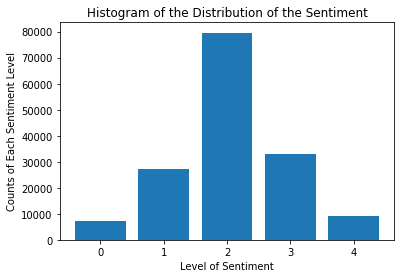

In [19]:
# Hầu hết các cụm từ được gắn nhãn 2, tức là trung lập
sentiment_labels = np.array([0,1,2,3,4])
sentiment_counts = data_phrase.groupby('Sentiment').count().Phrase
plt.bar(sentiment_labels, sentiment_counts, align='center')
plt.gca().set_xticks(sentiment_labels)
plt.title('Histogram of the Distribution of the Sentiment')
plt.xlabel('Level of Sentiment')
plt.ylabel('Counts of Each Sentiment Level')
plt.show()

In [20]:
# Bây giờ, chúng ta hãy có một chút trực giác về những câu được gắn nhãn là "trung lập"
data_sentence.query('Sentiment == 2').head()

,Sentence,Sentiment
SentenceId,,
18,Like a less dizzily gorgeous companion to Mr. ...,2
20,It 's everything you 'd expect -- but nothing ...,2
24,That the Chuck Norris `` grenade gag '' occurs...,2
25,The plot is romantic comedy boilerplate from s...,2
26,"It arrives with an impeccable pedigree , mongr...",2


In [22]:
# Tạo danh sách chứa tất cả các câu được gắn nhãn là "trung lập"
# Ở đây chúng tôi quan tâm nhiều hơn đến các câu hơn là các cụm từ vì có rất nhiều cụm từ được lặp lại
text_2 = " ".join(review for review in data_sentence.query('Sentiment == 2').Sentence)
# Tạo đối tượng WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=200, background_color="white").generate(text_2)

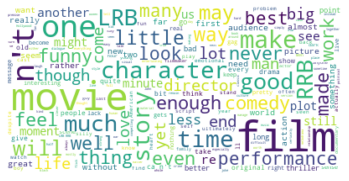

In [23]:
# Phác thảo từ ngữ của những đánh giá đó với tình cảm trung lập
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
# Bây giờ, chúng ta hãy khám phá những từ phổ biến nhất trong những câu được gắn nhãn 0 và 4, tức là "tiêu cực" và "tích cực"
# Ở đây, chúng tôi xác định một hàm để tạo biểu đồ để tránh một số mã lặp lại

# Đặt từ stop
stopwords = set(STOPWORDS)
stopwords.update(['movie','film','character','characters','story','one','make','will','is'])

def barplot(sentiment_level = 2):
    
    sentence = data_sentence.groupby('Sentiment').get_group(sentiment_level)
    text = " ".join(s for s in sentence.Sentence)
    
    wordcloud = WordCloud(stopwords=stopwords, max_words = 15).generate(text)
    
    labels = list(wordcloud.words_.keys())
    values = list(wordcloud.words_.values())

    plt.bar(labels, values, align='center', alpha = 0.9)
    plt.xticks(labels, rotation='vertical')
    plt.show()

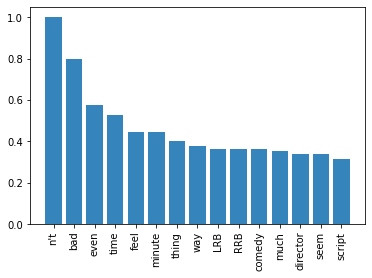

In [28]:
# 15 từ phổ biến đầu tiên trong câu có nhãn 0, tức là phủ định
# Chúng ta có thể thấy một số từ khó nghe như "bad", "n't"
# Tuy nhiên, những từ như "n't" cũng phổ biến trong câu có nhãn 2
barplot(0)

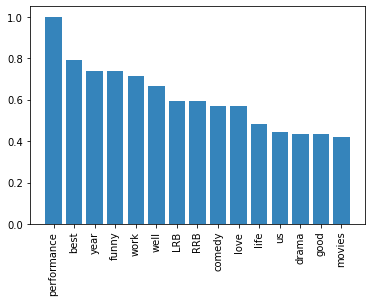

In [29]:
# 15 từ thông dụng đầu tiên trong câu được gắn nhãn 4, tức là tích cực
# Chúng ta có thể thấy một số từ tích cực như "best", "love", "good"
# Tuy nhiên, những từ như "good" cũng phổ biến trong câu có nhãn 2
barplot(4)

In [38]:
# Chúng ta sẽ xem từ đơn lẻ có thể đánh lừa chúng ta như thế nào
# Chúng ta có thể thấy rằng sentece sau với 2 "good", nhưng tình cảm là 1 (somewhat negative) !!
# Điều này là do một số từ như "but", "however" có thể thay đổi hướng của ngữ nghĩa hoàn toàn !!
data_phrase.iloc[0,1]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'